# Core 2020
# Taller Introducción al aprendizaje por refuerzo profundo para juegos en atari
## Libreta de entornos en python y métodos de programación dinámica.
*Por Roberto López-Díaz*



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC

### Entornos y clases base
Las siguientes son ejemplos de clases base para comenzar a crear un entorno de interés en el lenguaje de programacion de Python. Hacer estos no es estrictamente necesario, pero sirven como base para los métodos que todos los entornos necesitan tener para que las funciones escritas en base a estas clases funcionen sin problema. Algunos de estos estan basados en una interfaz popular de OpenAI llamada gym.

Hacer entornos se puede hacer con una mentalidad desconectada a usar algoritmos de aprendizaje por refuerzo, el objetivo es representar lo más fiel el fénomeno a estudiar. Como segunda meta, es adaptar este modelo o simulación del fenomeno con estas clases para generar una interfaz (también conocidas como API). Esto con la finalidad que diferentes algoritmos, personas o entornos diseñados alrededor de la API sufran pocos o ningún cambio para funcionar entre si.

In [ ]:
class actionSpace(ABC):
    """
    Discrete Action Space class.
    Stores all the posible actions for an environment and can generate
    samples with the method sample().

    Parameters
    ----------
    n: int
        Number of total actions. These are consider to be sequential.
    minValue: int
        Default 0. The minimum value that the action can take. It's
        the lower inclusive of the action space intervals 
        [minValue, minValue + n)
    """
    def __init__(self, n:int, minValue:int=0):
        assert n > 0, "Number of actions must be greater than 0"
        self.n = n
        self.mV = minValue
    
    @property
    def shape(self):
        return self.n

    def __iter__(self):
        self.actions = []
        self.i = 0
        for i in range(self.n):
            self.actions += [self.mV + i]
        return self
    
    def __next__(self):
        if self.i == self.n:
            raise StopIteration
        nx = self.actions[self.i]
        self.i += 1
        return nx

    def sample(self):
        """
        Returns a random sample with an uniform distribution of the
        actions.
        """
        return np.random.randint(self.mV, self.mV + self.n)

class Environment(ABC):
    """
    Environment base class.
    """
    def step(self, action):
        """
        Executes the action, updates the environment, calculates de reward and observation output.
        Returns
        -------
        observation, reward, done
        """
        raise NotImplemented
    def reset(self):
        """
        Restart the initial state of the environment, in a deterministic or stochastic manner
        Returns
        ------
        obeservation
        """
        raise NotImplemented
    def getObservation(self):
        """
        Calculates and returns the observation of the actual state of the environment.
        """
        raise NotImplemented
    def calculateReward(self, state):
        """
        Calculate with the actual mode the reward from the last observation made in the environment

        Returns
        -------
        reward
        """
        raise NotImplemented
    @property
    def actionSpace(self):
        """
        Returns the ActionShape class designed of the environment.
        """
        raise NotImplemented
    @property
    def stateSpace(self):
        """
        Returns a list or generator of all the states availables. 
        """
        raise NotImplemented
    def transProb(self, state, action):
        """
        Returns the probabilities and states of the transitions from the
        state and action given.
        """
        raise NotImplemented
    def isTerminal(self, state):
        """
        Returns the bool that expreses if the actual state is a terminal one
        or not.
        """
        raise NotImplemented

class Policy(ABC):
    """
    Policy base class.
    """
    def getAction(self, state):
        """
        Calculates and returns the corresponding action for the state given.
        """
        raise NotImplemented
    def update(self, state, action):
        """
        Update the action per state manner of the policy
        """
        raise NotImplemented

### Grid World; Primer entorno sencillo.
Un "mundo reticula", es un caso básico a analizar y encontrarle analogos a un entorno real podria resultar sencillo. Aunque se describa como sencillo, nos permite observar fenomenos interesantes en el contexto de aprendizaje por refuerzo.

Preguntas interesantes acerca de este entorno serían:
- ¿Que representación del estado seria suficiente?
- De crecer una columna o fila al entorno, ¿incrementa mucha nuestra complejidad computacional?
- ¿Qué utilidad podría tener un modelo así?

In [ ]:
class gridWorld(Environment):
    """
    Little and simple environment for a deterministic grid world.
    Parameters
    ----------
    width: int
        First dimension of the grid
    height: int
        Second dimension of the grid
    initPos: tuple of int
        Initial position of the agent.
    goal: tuple of int
        Position of the first goal to create the grid.
        One can add more goals later if required.
    movement: str
        Default 8C. Refer to step method.
    horizon: int
        Default 10**6. Number of steps to run the environment before it
        terminates.
    """
    # All gfx related
    EMPTYC = (255, 255, 255)
    OBST = 2
    OBSTC = (128, 64, 64)
    VORTEX = 3
    VORTEXC = (230, 0, 10)
    GOAL = 1
    GOALC = (0, 200, 20)
    AGENTC = (230, 150, 240)
    POLICYC = (0, 1, 0.5)
    CELLSIZE = 4
    GRAPHSCALE = 1.2    

    VORTEXD = [[False, True, True, False],
             [True, False, False, True],
             [True, False, False, True],
             [False, True, True, False]]

    AGENTD = [[False, True, True, False],
              [True, True, True, True],
              [True, True, True, True],
              [False, True, True, False]]

    GOALD = [[True, False, True, False],
             [False, True, False, True],
             [True, False, True, False],
             [False, True, False, True]]

    # Action meaning related
    actions  = [(-1,-1),(-1, 0),(-1,1),
              (0, -1),(0, 0),(0, 1),
              (1, -1),(1, 0),(1, 1)]

    actions4C = [1,3,4,5,7]

    def __init__(self, width:int, height:int, initPos:tuple, goal:tuple, movement:str = "4C", horizon:int = 10**6):
        # Grid Related
        self.grid = np.zeros((width, height), dtype=np.uint8)
        self._w = width
        self._h = height
        self.obstacles = []
        self.vortex = []
        self.goal = [goal]
        self.steps = 0
        self.gameOver = False
        self.horizon = horizon
        # Agent related
        self.movMode = movement
        self.validateTuple(initPos)
        self.initX, self.initY = initPos
        self.posX, self.posY = initPos
        self.__actionSpace = actionSpace(9 if movement == "8C" else 5, 1)
        # Graphics related
        self.frame = np.zeros((width * self.CELLSIZE, height * self.CELLSIZE, 3), dtype=np.uint8)
        # Initialize the grid
        self.reset()

    def validateTuple(self, T:tuple):
        assert len(T) == 2, "Tuple needs to have 2 items for x and y"
        if (T[0] < 0) or (T[1] < 0):
            raise ValueError("Values of the tuple must be non-negative")
        if (T[0] >= self._w) or (T[1] >= self._h):
            raise ValueError("Value of the tuple need to be in the interval x[0, {}), y[0, {})".format(self._w, self._h))
        return True
    
    def addVortex(self, *vortex):
        """
        Add a vortex on the grid
        Parameters
        ---------
        vortex: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put a new vortex.
        """
        for v in vortex:
            self.validateTuple(v)
            self.vortex += [v]

    def addObstacles(self, *obstacles):
        """
        Add an obstacle on the grid
        Parameters
        ---------
        obstacles: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put a new obstacle.
        """
        for o in obstacles:
            self.validateTuple(o)
            self.obstacles += [o]
    
    def addGoals(self, *goals):
        """
        Add a goal on the grid
        Parameters
        ---------
        goal: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put an additional goal.
        """
        for g in goals:
            self.validateTuple(g)
            self.goals += [g]

    def reset(self, initialPos = None):
        self.grid[:,:] = 0
        for o in self.obstacles:
            self.grid[o] = self.OBST
        for v in self.vortex:
            self.grid[v] = self.VORTEX
        for g in self.goal:
            self.grid[g] = self.GOAL
        if initialPos is None:
            self.posX = self.initX
            self.posY = self.initY
        else:
            self.validateTuple(initialPos)
            self.posX, self.posY = initialPos
        self.steps = 0
        self.gameOver = False
        self.lastObs = self.getObservation()
        self.lastReward = 0
        self.lastAction = 5
        return self.lastObs

    def step(self, action:int = 5):
        """
        Excecute a step on the environment. 
        The actions on the grid that the agent can take on mode 8C are
        integers from 1 to 9.

            [1  2  3]
            |4  5  6|
            [7  8  9]

        5 being the neutral action or "Do nothing"

        In mode 4C, the action space is reduced to just move in a cross 
        pattern with integers from 1 to 5

            [-  1  -]
            |2  3  4|
            [-  5  -]
        
        3 being the "do nothing" action.

        Parameters
        ----------
        action: int
            
        Returns
        -------
        observation , reward, done
        """
        # If the environment has reached a terminal state
        if self.gameOver:
            return self.lastObs, 0, True
        # Select the action from the corresponding transition probabilities
        randomSelect = np.random.uniform(0,1)
        probs, states = self.transProb(self.lastObs, action)
        lastP = 0
        for p, s in zip(probs, states):
            if randomSelect <= (p + lastP):
                self.posX, self.posY = s
                break
            else:
                lastP += p
        self.steps += 1
        # Check the horizon
        if self.steps > self.horizon:
            self.gameOver = True
        # Get new state and reward
        self.lastObs = self.getObservation(copy = False)
        self.lastReward = self.calculateReward(self.lastObs)
        return self.lastObs, self.lastReward, self.gameOver

    def validateAction(self, state, action:int):
        if self.movMode == "8C":
            assert (action > 0) and (action < 10), "Action must be an integer between 1 and 9"
            dx, dy = self.actions[action - 1]
        elif self.movMode == "4C":
            assert (action > 0) and (action < 6), "Action must be an integer between 1 and 5"
            dx, dy = self.actions[self.actions4C[action - 1]]
        self.lastAction = action
        posX, posY = state["agent"]
        # Tentative new position
        posX += dx
        posY += dy
        # Checking the movements be inside the grid
        if (posX < 0) or (posX >= self._w) or (posY < 0) or (posY >= self._h):
            # Is not inside the grid, this does nothing
            return state["agent"]
        # Checking if the movement gets it to an obstacle
        elif self.grid[posX, posY] == self.OBST:
            # Returns the same position as before
            return state["agent"]
        else:
            # No obstacle the new position is returned
            return posX, posY
    
    def calculateReward(self, state):
        # For each movement
        reward = -1 
        cellAgent = self.grid[state["agent"]]
        if cellAgent == self.VORTEX:
            # The agent has enter a vortex.
            reward += - 14
            self.gameOver = True
        elif cellAgent == self.GOAL:
            reward += 11
            self.gameOver = True
        return reward 

    def getObservation(self, copy:bool = True):
        if copy:
            return {"agent":(self.posX, self.posY), 
                    "grid": np.copy(self.grid)}
        else:
            return {"agent":(self.posX, self.posY), 
                    "grid": self.grid}

    def render(self, values=None, policy=None):
        # Suboptimal but simple to understand graphics for the environment
        fig = plt.figure(figsize=(self._w * self.GRAPHSCALE, self._h * self.GRAPHSCALE), clear = True)
        self.frame[:,:] = self.EMPTYC
        for i in range(self._w):
            for j in range(self._h):
                cell = self.grid[i,j]
                ni, nj = self.CELLSIZE * i, self.CELLSIZE * j
                f = self.frame[ni:ni+self.CELLSIZE,nj:nj+self.CELLSIZE]
                if cell == self.OBST:
                    f[:,:,:] = self.OBSTC
                elif cell == self.VORTEX:
                    f[self.VORTEXD,:] = self.VORTEXC
                elif cell == self.GOAL:
                    f[self.GOALD,:] = self.GOALC
                if values is not None:
                    plt.text(nj + 1.5, ni + 1.5, str(np.round(values[i,j], 2)),
                             horizontalalignment='center',
                             verticalalignment='center',)
                if policy is not None and (cell == 0):
                    action = policy.getAction((i,j)) - 1
                    if self.movMode == "4C":
                        action = self.actions4C[action]
                    dx, dy = self.actions[action]
                    plt.arrow(nj + 1.5, ni + 1.5, 1.5 * dy, 1.5 * dx, width=0.2, color=self.POLICYC)
        ni, nj = self.posX * self.CELLSIZE, self.posY * self.CELLSIZE
        f = self.frame[ni:ni+self.CELLSIZE,nj:nj+self.CELLSIZE,:] 
        f[self.AGENTD,:] = self.AGENTC
        plt.title("GridWorld {}x{} Action {} Reward {}".format(self._w, self._h, 
                                                               self.lastAction, 
                                                               self.lastReward))
        plt.imshow(self.frame)
        plt.axis("off")

    def updateGrid(self):
        pass

    @property
    def actionSpace(self):
        return self.__actionSpace

    @property
    def stateSpace(self):
        states = []
        for i in range(self._w):
            for j in range(self._h):
                if not self.grid[i,j] == self.OBST:
                    states += [(i,j)]
        return states

    def transProb(self, state, action):
        # Deterministic Environment
        state = self.validateAction(state, action)
        return [1], [state]

    def isTerminal(self, state):
        if isinstance(state, dict):
            cellAgent = self.grid[state["agent"]]
        else:
            cellAgent = self.grid[state]
        if cellAgent == self.VORTEX or cellAgent == self.GOAL:
            return True
        else:
            return False

    @property
    def shape(self):
        return self.grid.shape

### Controlador del agente
Los agentes en RL en realidad son un conjunto de varios elementos disintos para lograr tomar las decisiones con el entorno. Para el entorno anterior, se generan dos clases nuevas de politicas sencillas. Una que es siempre aleatoria con probabilidad uniforme, y otra que se inicializa aleatoriamente pero se comporta de manera deterministica.



In [ ]:
class uniformRandomPolicy(Policy):
    def __init__(self, env:Environment):
        self.pi = env.actionSpace
        self.env = env

    def getAction(self, state):
        return self.pi.sample()

    def update(self, state, action):
        pass # Do nothing

class gridPolicy(Policy):
    def __init__(self, env:Environment):
        self.pi = np.zeros(env.shape, dtype=np.uint8)
        # or could be a dict() as well
        self.env = env
        self.randomInit()

    def randomInit(self):
        for state in self.env.stateSpace:
            self.pi[state] = self.env.actionSpace.sample()

    def update(self, state, action):
        if isinstance(state, dict):
            state = state["agent"]
        self.pi[state] = action

    def getAction(self, state):
        if isinstance(state, dict):
            state = state["agent"]
        return self.pi[state]

### A comenzar a jugar con el entorno GridWorld!
Las celdas ejecutadas son del código muestra como el autor las diseño, sus configuraciones no tienen justificación en particulas más que mostrar el funcionamiento. 

Los resultados de los códigos a escribir están basados en esos, pero aun asi cambia todo lo que haga contento tu corazón. Resultados a otras reticulas pueden ser comparados en el classroom. 

In [ ]:
env = gridWorld(6,6,(0,0),(4,4),movement="8C") # Iniciar el entorno
randomPolicy = uniformRandomPolicy(env) # Crear una politica
env.addObstacles((4,3),(2,2),(0,1),(0,2)) # Añadimos algunos obstaculos
env.addVortex((4,2)) # Añadimos otros obstaculos que se comportan como un torbellino
obs = env.reset() # Reiniciamos el entorno para que vuelva a cargar todo lo anterior

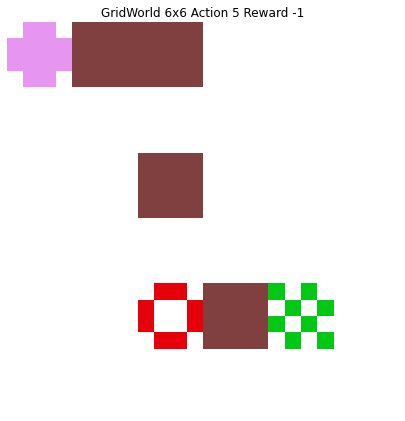

In [ ]:
obs, reward, done = env.step(randomPolicy.getAction(obs))
env.render()

## Evaluación de la politica
Todos pseudo códigos fueron extraidos del libro de Suton Y Barto.
#### Pseudocódigo de Iterative Policy Evaluation
Input $\pi$, the policy to be evaluated
Algorithm parameter: a small threshold $\theta > 0$ determining accuracy of estimation
Initialize $V(s)$, for al $s\in \mathit{S^+}$, arbitrarilly except that $V(terminal) = 0$

Loop:
- $\Delta \leftarrow 0$
- Loop for each $s\in \mathit{S}$:
    - $v \leftarrow V(s)$
    - $V(s) \leftarrow \Sigma_a \pi(a|s)\Sigma_{s',r}p(s',r | s, a)[r+\gamma V(s')]$
    - $\Delta \leftarrow \max(\Delta, |v-V(s)|)$

until $\Delta < \theta$

In [ ]:
def policyEvaluation(env:Environment, policy:Policy, k:int, thres:float = 0.01, gamma:float = 0.99):
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    # Initialization
    V = np.zeros(env.shape, dtype=np.float32)
    states = env.stateSpace
    actions = env.actionSpace
    diff = 0
    # Policy evaluation
    # Iteration as stop condition
    for _ in range(k):
        # Do a copy of V_t to be V_{t - 1}
        Vpass = np.copy(V)
        # Iterate the states of the environment
        for state in states:
            # Check if the state is terminal
            if env.isTerminal(state):
                V[state] = 0
                continue # With this the next code is not not executed
            # Get the action from the policy
            action = policy.getAction(state)
            # Get the probabilities and next states corresponding to the
            # actual state and action
            probs, nextStates = env.transProb({"agent":state}, action)
            sum = 0
            for p, s in zip(probs, nextStates):
                r = env.calculateReward({"agent":s})
                sum += p * (r + gamma * Vpass[s])
            # Update the value function given pi
            V[state] = sum
            diff = max(diff, Vpass[state] - sum)
        # First condition
        if diff < thres:
            return V
    return V

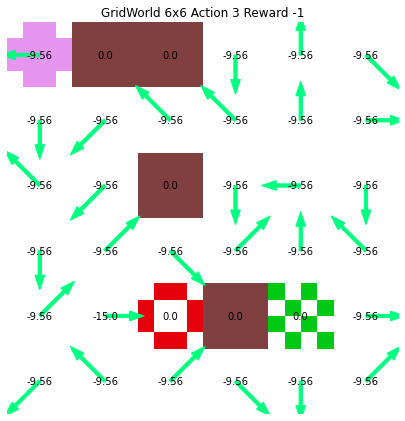

In [ ]:
policy = gridPolicy(env)
vp = policyEvaluation(env, policy, 10, 0.1)
env.render(vp, policy)

## Mejora de la politica con Iteración de politica
1. Initialization $V(s)\in \mathbb{R} $ and $ \pi(s)\in \mathit{A}(s)$
2. Policy Evaluation.
3. Policy improvemente
    - $\text{policy-stable} \leftarrow \text{true}$
    - For each $s\in \mathit(S)$:
        - $old-action \leftarrow \pi(s)$
        - $\pi(s)\leftarrow \arg \max_a \Sigma_{s',r}p(s', r | s,a)[r + \gamma V(s')] $
        - If $\text{old-action} \neq \pi(s)$,  $\text{policy-stable} \leftarrow false$

if $\text{policy-stable}$, then stop and return $V$, else return to step 2.   

In [ ]:
def policyIteration(env:Environment, policy:Policy, k_eva:int, k_improvement:int, thres:float = 0.01, gamma:float = 0.99,):
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert k_improvement > 0, "k needs to be am integer greater or equal to 1 iteration."
    # Initialization
    states = env.stateSpace
    actions = env.actionSpace
    # Iteration as alternate stop condition
    for improvement in range(k_improvement):
        # Policy evaluation
        V = policyEvaluation(env, policy, k_eva, thres = thres, gamma = gamma)
        # Policy improvement
        policyStable = True
        # Iterate the states
        for state in states:
            oldAction = policy.getAction(state)
            maxSum = - np.inf
            maxAction = None
            for action in actions:
                probs, nextStates = env.transProb({"agent":state}, action)
                sum = 0
                for p, s in zip(probs, nextStates):
                    r = env.calculateReward({"agent":s})
                    sum += p * (r + gamma * V[s])
                if sum > maxSum:
                    maxSum = sum
                    maxAction = action
            # Update the policy with the new action which gives
            # more reward        
            policy.update(state, maxAction)
            if maxAction != oldAction:
                policyStable = False
        # Stop condition check
        if policyStable == True:
            print("Policy stable afer {} iterations".format(improvement))
            return V
    print("Stopped after all the iterations")
    return V

Policy stable afer 5 iterations


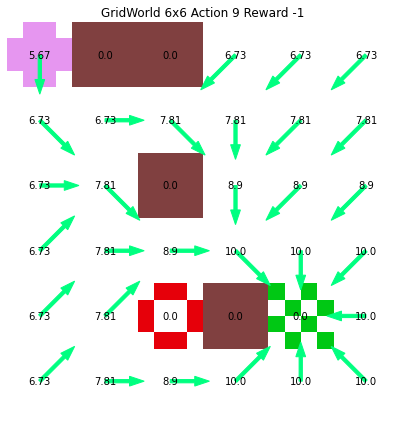

In [ ]:
vp = policyIteration(env, policy, 10, 50, 0.99)
env.render(vp, policy)

## Value Iteration
### Pseudocode
Algorithm parameter: a small threshold $\theta > 0$ determining accuracy of estimation.

Initialize $V(s)$, for all $a\in \mathit{S^+}$, arbitrarily except that $V(terminal)=0$

Loop:
- $\Delta \leftarrow 0$
- Loop for each $s\in \mathit{S}$:
    - $v \leftarrow V(s)$
    - $V(S) \leftarrow \max_a \Sigma_{s',r}p(s', r | s,a)[r + \gamma V(s')]$
    - $\Delta \leftarrow \max(\Delta, |v-V(s)|)$

until $\Delta < 0$

Output a deterministic policy, $\pi \approx \pi_*$, such that

$\pi(s) = \arg \max_a \Sigma_{s',r} p(s',r| s, a)[r+\gamma V(s')]$

In [ ]:
def valueIteration(env:Environment, k:int, thres:float = 0.01, gamma:float = 0.99):
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    actions = env.actionSpace
    states = env.stateSpace
    V = np.zeros(env.shape, dtype=np.float32)
    diff = 0
    # Start the iterations
    for iteration in range(k):
        # Do a copy of V_t as is now V_{t-1}
        Vpass = np.copy(V)
        # For each state of all available
        for state in states:
            maxSum = - np.inf
            maxAction = None
            stateDict = {"agent": state}
            # If the state is terminal assign V(s) = 0
            if env.isTerminal(stateDict):
                V[state] = 0
                continue # With this the next code is not not executed
            # For each action available
            for action in actions:
                # Get from the mode the probabilities and their
                # corresponding next states given the actual state
                probs, nextStates = env.transProb(stateDict, action)
                sum = 0
                # For each pair of the probability and its state
                for p, s in zip(probs, nextStates):
                    r = env.calculateReward({"agent":s})
                    sum += p * (r + gamma * Vpass[s])
                if sum > maxSum:
                    maxSum = sum
                    maxAction = action
            V[state] = maxSum
            diff = max(diff, Vpass[state] - maxSum)
        # First stop condition
        if diff < thres:
            return V
    return V

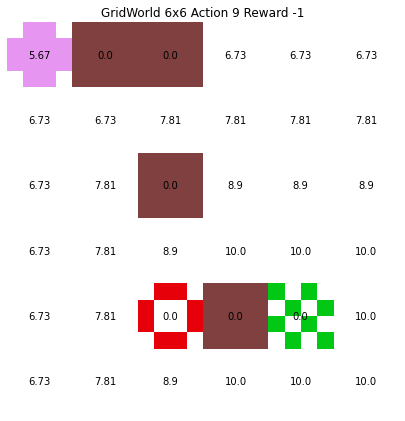

In [ ]:
vi = valueIteration(env, 100, 0.99)
env.render(vi)

### Una nueva variante, un mundo con probabilidades

In [ ]:
class stochasticGridWorld(gridWorld):
    """
    A modification to the GridWorld to add moving vortex with random directions.
    This movements follow the same type of movement as the agent.

    Parameters
    ----------
    width: int
        First dimension of the grid
    height: int
        Second dimension of the grid
    initPos: tuple of int
        Initial position of the agent.
    goal: tuple of int
        Position of the first goal to create the grid.
        One can add more goals later if required.
    movement: str
        Default 8C. Refer to step method.
    horizon: int
        Default 10**6. Number of steps to run the environment before it
        terminates.

    """
    def __init__(self, width:int, height:int, initPos:tuple, goal:tuple, movement:str = "4C", horizon:int = 10**6):
        super().__init__(width, height, initPos, goal, movement, horizon)
        self.vortexProb = []

    def addVortex(self, *vortex):
        """
        Add a stochastic atraction vortex on the grid
        Parameters
        ---------
        vortex: tuple
            A tuple with the form (x,y,p). x and y are integers 
            which cointain the initial position to put a new vortex.
            While p is a float in [0,1) that the vortex will attract the
            agent to it even if it's not leading to it.
        """
        for v in vortex:
            assert len(v) == 3, "The tuple must cointain two integers as position and third float number to express the probability"
            self.validateTuple(v[:2])
            self.vortex += [v[:2]]
            p = v[2]
            assert (p >= 0) and (p < 1), "The probability; third item on the tuple needs to be between 0 and 1"
            self.vortexProb += [v[2]]
    
    def transProb(self, state, action):
        # Local function
        def nearby(pos:tuple, vortex:tuple, diag:bool):
            d1 = abs(pos[0] - vortex[0])
            d2 = abs(pos[1] - vortex[1])
            if (d1 <= 1) and (d2 <= 1) and (diag == True):
                return True
            elif ((d1 == 1 and d2 == 0) or (d1 == 0 and d2 == 1)) and (diag == False):
                return True
            else:
                return False
        # Checking state type
        if isinstance(state, dict):
            agent = state["agent"]
        else:
            agent = state
        # Init
        states = []
        probs = []
        # Check if the agent is nearby 1 cell of the effect of the vortex
        for v, p in zip(self.vortex, self.vortexProb):
            if nearby(agent, v, True if self.movMode == "8C" else False):
                states += [v]
                probs += [p]
        # Add the action state
        states += [self.validateAction(state, action)]
        n = len(states) - 1
        if n == 0:
            probs = [1]
        else:
            probs += [n - sum(probs)]
            # Normalize the probabilities
            probs = np.array(probs, dtype=np.float32)
            probs = probs / n 
        return probs, states


In [ ]:
envs = stochasticGridWorld(6,6,(0,0), (5,5), movement="8C")
envs.addVortex((1,2,0.9), (2,2,0.7), (5,4, 0.5))
envs.addObstacles((4,3),(2,2),(0,1),(0,2))

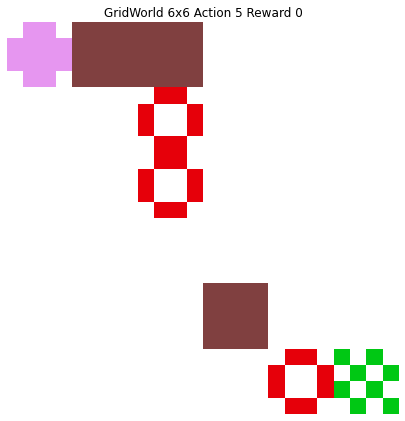

In [ ]:
envs.reset()
envs.render()

In [ ]:
envs.transProb({"agent":(1,1)},5)

(array([0.45, 0.35, 0.2 ], dtype=float32), [(1, 2), (2, 2), (1, 1)])

Policy stable afer 7 iterations


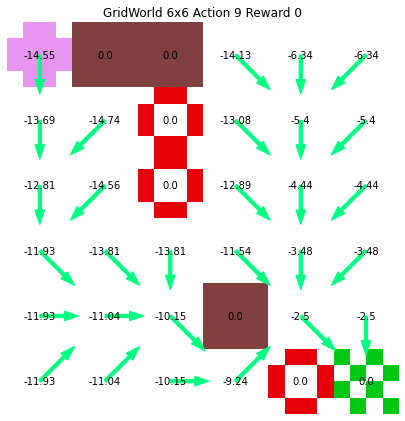

In [ ]:
spolicy = gridPolicy(envs)
vp = policyIteration(envs, spolicy, 20, 20)
envs.render(vp, spolicy)

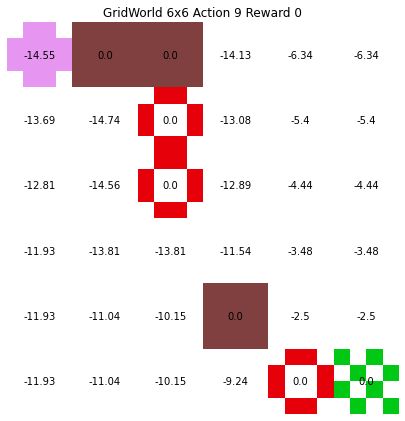

In [ ]:
vi = valueIteration(envs, 100)
envs.render(vi)